In [73]:
### Import the required libraries
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.nn.functional as F
import xarray as xr

## Spin-up of a mountain glacier

We now generate the true solution for a simple mountain glacier model, taken from *Fundamentals of Glacier Dynamics* by CJ van der Veen and then look to make our neural network model *emulate* this PDE. The system is modeled by a non-linear, highly diffusive PDE.

$$
 \frac{\partial H}{\partial t } = -\frac{\partial}{\partial x}\left(-D(x)\frac{\partial h}{\partial x}\right) + M\\
  D(x) = CH^{n+2}\left|\frac{\partial h}{\partial x}\right|^{n-1}\\
  C = \frac{2A}{n+2}(\rho g)^n\\
    H(x,t) = h(x,t) - b(x) \\ 
    H_l = 0, H_r > 0
$$

$$\frac{\partial{b}}{\partial{x}} = -0.1\\
M(x) = M_0 - x M_1 \:\text{(accumulation rate, essentially a source term)}\\
M_0 = 4.0 \:\text{m/yr}, \:M_1 = 0.0002 \:\text{yr}^{-1}\\
\rho = 920 \:\text{kg/m}^3\\
g = 9.8 \:\text{m/s}^2\\
A = 10^{-16} \: \text{Pa}^{-3} \text{a}^{-1}\\
n = 3\\
dx = 500 \:\text{m}, \:L = 12000 \:\text{m}\\
dt = 2/52 \:\text{yr}, \:T = 1500 \:\text{yr}$$

$$
v_{x, \text{surface}} = \frac{2A}{n+1} \tau_d^n H \left\{ \phi + 1 \right\}
$$

The true solution will be generated using a staggered grid finite volume method on a fine, uniform grid.



In [74]:
class True_Solution:
    
    def __init__(self, L, T, dx, dt, accum_rate_func, basal_topology_func, H_init = None):
        
        self.L = L
        self.T = T
        self.dx = dx
        self.dt = dt
        self.nx = int(L/dx)
        self.nt = int(T/dt)
        self.x = np.linspace(0, self.L, self.nx + 1)
        self.t = np.linspace(0, self.T, self.nt + 1)
        
        if H_init is not None:
            self.H_init = H_init
        else:
            self.H_init = np.zeros(self.nx + 1)
            
        self.accum_rate_func = accum_rate_func
        self.basal_topology_func = basal_topology_func

    def create_Dataset(self):
    
        self.ds = xr.Dataset()
        
        Dict = {}
        Dict['number of model grid points in x-direction'] = self.nx + 1
        Dict['number of time points'] = self.nt + 1
        Dict['number of time steps'] = self.nt
        
        self.ds = self.ds.expand_dims(Dict)
        
        self.ds = xr.Dataset({
        'H_init': xr.DataArray(
                data   = self.H_init,
                dims   = ['number of model grid points in x-direction'],
                coords = {'number of model grid points in x-direction': self.x},
                attrs  = {'units': 'm', 'Description': 'User input for initial ice thickness'}
                ),
        'x': xr.DataArray(
                data   = self.x,
                dims   = ['number of model grid points in x-direction'],
                coords = {'number of model grid points in x-direction': self.x},
                attrs  = {'units': 'm', 'Description': 'x-grid co-ordinates'}
                ),
        't': xr.DataArray(
                data   = self.t,
                dims   = ['number of time points'],
                coords = {'number of time points': self.t},
                attrs  = {'units': 'a', 'Description': 'time co-ordinates'}
                ),
        'dx': xr.DataArray(
                data   = self.dx,
                attrs  = {'units': 'm', 'Description': 'x-grid cell size'}
                ),
        'dt': xr.DataArray(
                data   = self.dt,
                attrs  = {'units': 'a', 'Description': 'time step size'}
                ),
        'n': xr.DataArray(
                data   = 3,
                attrs  = {'units': None, 'Description': 'Glen flow law exponent'}
                ),
        'A': xr.DataArray(
                data   = 1.e-16,
                attrs  = {'units': 'Pa^-3 a^-1', 'Description': 'Arrhenius law pre-exponential constant'}
                ),
        'g': xr.DataArray(
                data   = 9.2,
                attrs  = {'units': 'm s^-2', 'Description': 'Acceleration due to gravity'}
                ), 
        'rho': xr.DataArray(
                data   = 920,
                attrs  = {'units': 'kg m^-3', 'Description': 'Density of ice'}
                ),
        'b': xr.DataArray(
                data   = self.basal_topology_func(self.x, self.L),
                dims   = ['number of model grid points in x-direction'],
                coords = {'number of model grid points in x-direction': self.x},
                attrs  = {'units': 'm', 'Description': 'Basal topography'}
                )
            }
        )    
        
        self.ds['C'] = ([], 
                       2*self.ds.variables['A']/(self.ds.variables['n']+2) 
                        * (self.ds.variables['rho']*self.ds.variables['g'])**self.ds.variables['n'])
        self.ds['C'].attrs['units'] = 'Pa^-3 a^-1 kg^3 m^-6 s^-6'
        self.ds['C'].attrs['Description'] = 'Coefficient of topography dependent diffusion coefficient'
        
    def solve(self):

        b = self.ds['b'].values
        C = self.ds['C'].values
        H_init = self.ds['H_init'].values
        n = self.ds['n'].values
        rho = self.ds['rho'].values
        g = self.ds['g'].values
        A = self.ds['A'].values
        
        dx = self.dx
        dt = self.dt
        x = self.x
        t = self.t
        nx = self.nx
        nt = self.nt
        
        
        M = np.zeros((nx+1,nt+1), dtype = float)
        M[:,0] = accum_rate_func(b)

        h = np.zeros((nx+1,nt+1))
        H = np.zeros((nx+1,nt+1))
        
        H[:,0] = H_init

        h[:,0] = b + H[:,0]
        h[0,:] = b[0]
        h[-1,:] = b[-1]

        for i in range(1,len(t)):

            D = C *((H[1:,i-1]+H[:nx,i-1])/2.0)**(n+2) * ((h[1:,i-1] - h[:nx,i-1])/dx)**(n-1)
            
            phi = -D*(h[1:,i-1]-h[:nx,i-1])/dx

            h[1:nx,i] = h[1:nx,i-1] + M[1:nx,i-1]*dt - dt/dx * (phi[1:]-phi[:nx-1])

            h[1:nx,i] = (h[1:nx,i] < b[1:nx]) * b[1:nx] + (h[1:nx,i] >= b[1:nx]) * h[1:nx,i]
            H[:,i] = h[:,i] - b
            
            M[:,i] = accum_rate_func(h[:,i])

        alpha_sx = np.zeros((nx+1,nt+1))
        tau_d = np.zeros((nx+1,nt+1))
        alpha_sx[0, :] = (h[1, :] - h[0, :]) / dx
        alpha_sx[-1, :] = (h[-1, :] - h[-2, :]) / dx
        alpha_sx[1:-1, :] = (h[2:, :] - h[:-2, :]) / (2*dx)
        tau_d = - rho * g * H * alpha_sx
        phi = 0.0

        vx_s = 2*A/(n+2) * (tau_d)**n * H * (phi + 1)
        
        volume = np.sum(H*dx, axis = 0)
        
        self.ds['H'] = (['number of model grid points in x-direction', 'number of time points'], H)
        self.ds['H'].attrs['units'] = 'm'
        self.ds['H'].attrs['Description'] = 'Ice thickness'
        
        self.ds['h'] = (['number of model grid points in x-direction', 'number of time points'], h)
        self.ds['h'].attrs['units'] = 'm'
        self.ds['h'].attrs['Description'] = 'Ice surface topography'
        
        self.ds['M'] = (['number of model grid points in x-direction', 'number of time points'], M)
        self.ds['M'].attrs['units'] = 'm a^-1'
        self.ds['M'].attrs['Description'] = 'Surface accumulation rate'
        
        self.ds['vx_s'] = (['number of model grid points in x-direction', 'number of time points'], vx_s)
        self.ds['vx_s'].attrs['units'] = 'm a^-1'
        self.ds['vx_s'].attrs['Description'] = 'Surface x-velocity'
        
        self.ds['alpha_sx'] = (['number of model grid points in x-direction', 'number of time points'], alpha_sx)
        self.ds['alpha_sx'].attrs['units'] = ''
        self.ds['alpha_sx'].attrs['Description'] = 'Surface x-slope'
        
        self.ds['tau_d'] = (['number of model grid points in x-direction', 'number of time points'], tau_d)
        self.ds['tau_d'].attrs['units'] = 'Pa'
        self.ds['tau_d'].attrs['Description'] = 'Basal drag in x-direction'
        
        self.ds['volume'] = (['number of time points'], volume)
        self.ds['volume'].attrs['units'] = 'm^3'
        self.ds['volume'].attrs['Description'] = 'Volume of ice sheet'

In [75]:
def accum_rate_func(h, beta = 0.001, head = 4900, ela = 4100):
    
    # mass balance parameters 
    # beta = 0.001 m ice eq /yr 
    # head = 4900 glacier head m asl. 
    # ela = 4100 m 
    
    M = beta*(h - ela)
    M = (h > head)*0.0 + (h <= head)*M
    return M

def basal_topology_func(x,L):
    b = 5000.0 - x*np.tan(np.pi*10/180) + 200.0*np.sin(np.pi*(0.5+4*x/L))
    return b

TS = True_Solution(12000, 1500, 100.0, 2./52., accum_rate_func, basal_topology_func)

TS.create_Dataset()

TS.solve()

In [76]:
TS.ds

<xarray.Dataset>
Dimensions:                                     (
                                                 number of model grid points in x-direction: 121,
                                                 number of time points: 39001)
Coordinates:
  * number of model grid points in x-direction  (number of model grid points in x-direction) float64 ...
  * number of time points                       (number of time points) float64 ...
Data variables: (12/18)
    H_init                                      (number of model grid points in x-direction) float64 ...
    x                                           (number of model grid points in x-direction) float64 ...
    t                                           (number of time points) float64 ...
    dx                                          float64 100.0
    dt                                          float64 0.03846
    n                                           int64 3
    ...                                          ...
    h                                           (number of model grid points in x-direction, number of time points) float64 ...
    M                                           (number of model grid points in x-direction, number of time points) float64 ...
    vx_s                                        (number of model grid points in x-direction, number of time points) float64 ...
    alpha_sx                                    (number of model grid points in x-direction, number of time points) float64 ...
    tau_d                                       (number of model grid points in x-direction, number of time points) float64 ...
    volume                                      (number of time points) float64 ...

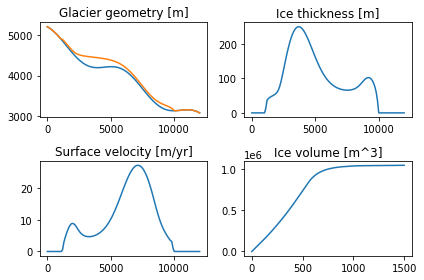

In [77]:
fig, axs = plt.subplots(2, 2)

axs[0,0].plot(TS.ds['x'],TS.ds['b'], label = "Basal topography")
axs[0,0].plot(TS.ds['x'],TS.ds['h'][:,-1], label = "Ice Surface")
axs[0,0].set_title("Glacier geometry [m]")

axs[0,1].plot(TS.ds['x'],TS.ds['H'][:,-1], label = "Ice thickness")
axs[0,1].set_title("Ice thickness [m]")

axs[1,0].plot(TS.ds['x'],TS.ds['vx_s'][:,-1], label = "Surface velocity")
axs[1,0].set_title("Surface velocity [m/yr]")

axs[1,1].plot(TS.ds['t'],TS.ds['volume'])
axs[1,1].set_title("Ice volume [m^3]")

fig.tight_layout()

In [78]:
A = 1e-16
n = 3
rho = 920.0
g = 9.2 
dx = 100.0 # m
dt = 2./52. # yr

def accum_rate_func(h, beta = 0.001, head = 4900, ela = 4100):
    
    # mass balance parameters 
    # beta = 0.001 m ice eq /yr 
    # head = 4900 glacier head m asl. 
    # ela = 4100 m 
    
    M = beta*(h - ela)
    M = (h > head)*0.0 + (h <= head)*M
    return M

def basal_topology_func(x,L):
    b = 5000.0 - x*np.tan(np.pi*10/180) + 200.0*np.sin(np.pi*(0.5+4*x/L))
    return b

def spin_up(L, T, accum_rate_func, basal_topology_func):



    nx = int(L/dx)
    nt = int(T/dt)
    x = np.linspace(0,L,nx+1)
    t = np.linspace(0,T,nt+1)

    b = basal_topology_func(x,L)
    M = accum_rate_func(b)

    C = 2*A/(n+2) * (rho*g)**n

    h = np.zeros((nx+1,nt+1))
    H = np.zeros((nx+1,nt+1))
    h[:,0] = b
    h[0,:] = b[0]
    h[-1,:] = b[-1]

    H[:,0] = h[:,0] - b
    H[0,:] = h[0,:] - b[0]
    H[-1,:] = h[-1,:] - b[-1]

    for i in range(1,len(t)):

        D = C *((H[1:,i-1]+H[:nx,i-1])/2.0)**(n+2) * ((h[1:,i-1] - h[:nx,i-1])/dx)**(n-1)
        
        phi = -D*(h[1:,i-1]-h[:nx,i-1])/dx

        h[1:nx,i] = h[1:nx,i-1] + M[1:nx]*dt - dt/dx * (phi[1:]-phi[:nx-1])
        
        h[1:nx,i] = (h[1:nx,i] < b[1:nx]) * b[1:nx] + (h[1:nx,i] >= b[1:nx]) * h[1:nx,i]
        H[:,i] = h[:,i] - b
        
        M = accum_rate_func(h[:,i])

    alpha_sx = np.zeros((nx+1,nt+1))
    tau_d = np.zeros((nx+1,nt+1))
    alpha_sx[0, :] = (h[1, :] - h[0, :]) / dx
    alpha_sx[-1, :] = (h[-1, :] - h[-2, :]) / dx
    alpha_sx[1:-1, :] = (h[2:, :] - h[:-2, :]) / (2*dx)
    tau_d = - rho * g * H * alpha_sx
    phi = 0.0

    vx_surface = 2*A/(n+2) * (tau_d)**n * H * (phi + 1)

    return x, t, H, h, b, vx_surface, alpha_sx, C

In [79]:
L = 12000.
T = 1500.

x, t, H_spinup, h_spinup, b_spinup, vx_surface_spinup, alpha_sx_spinup, C_spinup = spin_up(L, T, accum_rate_func, basal_topology_func)
vol_spinup = np.sum(H_spinup*dx, axis = 0) # km^3

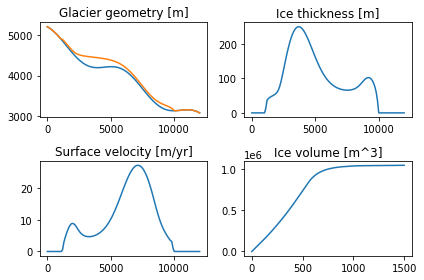

In [80]:
fig, axs = plt.subplots(2, 2)

axs[0,0].plot(x,b_spinup, label = "Basal topography")
axs[0,0].plot(x,h_spinup[:,-1], label = "Ice Surface")
axs[0,0].set_title("Glacier geometry [m]")

axs[0,1].plot(x,H_spinup[:,-1], label = "Ice thickness")
axs[0,1].set_title("Ice thickness [m]")

axs[1,0].plot(x,vx_surface_spinup[:,-1], label = "Ice thickness")
axs[1,0].set_title("Surface velocity [m/yr]")

axs[1,1].plot(t,vol_spinup)
axs[1,1].set_title("Ice volume [m^3]")

fig.tight_layout()

## We now compare our result with the analytical formula given in Millian et.al Nature 2022.

Assume that the basal velocity is zero, therefore $\beta = 0$.

In [ ]:
H_analytical = vx_surface_spinup[:,-1]*(n+1) / (2*A*(rho*g)**n*abs(alpha_sx_spinup[:,-1])**n)
H_analytical = H_analytical ** (1/(n+1))

In [ ]:
plt.plot(x,H_spinup[:,-1], label = "True Ice thickness")
plt.plot(x,H_analytical, label = "Analytical Ice thickness")
plt.title("Ice thickness [m]")
plt.legend()

## PINN for deterministic inversion of $b$ for steady state case

In [ ]:
class PINN(nn.Module):
    
    def __init__ (self):

        super(PINN, self).__init__()

        self.fc1 = nn.Linear(1,20)
        self.fc2 = nn.Linear(20,20)
        self.fc3 = nn.Linear(20,20)
        self.fc4 = nn.Linear(20,20)
        self.fc5 = nn.Linear(20,20)
        self.fc6 = nn.Linear(20,20)
        self.fc7 = nn.Linear(20,20)
        self.fc8 = nn.Linear(20,20)
        self.fc9 = nn.Linear(20,20)
        self.fc10 = nn.Linear(20,20)
        self.fc11 = nn.Linear(20,20)
        self.fc12 = nn.Linear(20,1)

    def forward(self, x):
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = torch.relu(self.fc7(x))
        x = torch.relu(self.fc8(x))
        x = torch.relu(self.fc9(x))
        x = torch.relu(self.fc10(x))
        x = torch.relu(self.fc11(x))
        x = self.fc12(x)
        
        return x

PINN

In [ ]:
### Collocation points
# N_c = 1000 # Number of collocation points
# x_c = torch.unsqueeze(torch.from_numpy(L*np.random.rand(N_c)), 1)
x_c = torch.unsqueeze(torch.from_numpy(x).float(), 1)

### Data
h_data = torch.unsqueeze(torch.from_numpy(h_spinup[:,-1]).float(), 1)
vx_data = torch.unsqueeze(torch.from_numpy(vx_surface_spinup[:,-1]).float(), 1)
x_data = torch.unsqueeze(torch.from_numpy(x).float(), 1)

### Parameters
C = C_spinup

C

In [ ]:
b_true = torch.unsqueeze(torch.from_numpy(b_spinup), 1).float()
b = torch.zeros_like(x_c, requires_grad = True)

pinn = PINN()
criterion = nn.MSELoss()

adam = torch.optim.Adam(pinn.parameters(), lr = 1e-3)
adam.add_param_group({'params': b, 'lr': 5.0e1})
                             
my_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=adam, step_size=2000, gamma=0.9
)

In [ ]:
statistics = []
for epochs in range(50000):

    x_c_clone = x_c.clone()
    x_c_clone.requires_grad = True
    x_d_clone = x_data.clone()
    x_d_clone.requires_grad = True
    
    h = pinn(x_c_clone/12000.0)
    
    M = accum_rate_func(h)

    grad_h = torch.autograd.grad(torch.sum(h), x_c_clone, create_graph=True)
    h_x = grad_h[0]
    hess_h = torch.autograd.grad(torch.sum(h_x), x_c_clone, create_graph=True)
    h_xx = hess_h[0]

    flux = - C * torch.pow(torch.squeeze(torch.sub(h, b)), n+2) * torch.pow(torch.abs(h_x), n-1) * h_x
    gradients_flux = torch.autograd.grad(torch.sum(flux), x_c_clone, create_graph=True)
    flux_x = - gradients_flux[0]
    pde_rhs = M + flux_x

    ### Separate data points
    #     h_d = pinn(x_d_clone)
    #     H_d = torch.sub(h_d, b)
    #     alpha = torch.autograd.grad(torch.sum(h_d), x_d_clone, create_graph=True)
    #     tau_d = - rho * g * H_d * alpha[0]
    #     phi = 0.0
    #     vx_d = 2*A/(n+2) * (tau_d)**n * H_d * (phi + 1)

    #     vx_d_loss = criterion(vx_d, vx_data)
    #     h_d_loss = criterion(pinn(x_d_clone), h_data)
    
    ### Data points same as collocation points
    tau = - rho * g * torch.sub(h, b) * h_x
    phi = 0.0
    vx = 2*A/(n+2) * (tau)**n * torch.sub(h, b) * (phi + 1)
    vx_d_loss = 1000*criterion(vx, vx_data)
    
    adam.zero_grad() 
    h_d_loss = 1e7*criterion(h, h_data)
    b_loss = criterion(b, b_true)
    if (b_loss <= 1.5e3):
        break
    c_loss = 1000*criterion(pde_rhs, torch.zeros_like(pde_rhs))
    l_loss = 5000*torch.linalg.norm(torch.sub(b[0], b_true[0])) \
            + 5000*torch.linalg.norm(torch.sub(h[0], b_true[0]))
    r_loss = 5000*torch.linalg.norm(torch.sub(b[-1], b_true[-1])) \
            + 5000*torch.linalg.norm(torch.sub(h[-1], b_true[-1]))
    b_less_h_loss = 1e5*torch.sum(torch.nn.functional.relu(-torch.sub(h, b)))
    loss =  h_d_loss + l_loss + r_loss + c_loss + b_less_h_loss + vx_d_loss
    loss.backward()  
    
    adam.step()
    my_lr_scheduler.step()
        
    if ((epochs+1) % 100 == 0):
        statistics.append([epochs, 
                            loss.data.numpy(), 
                            l_loss.data.numpy(), 
                            r_loss.data.numpy(), 
                            c_loss.data.numpy(), 
                            h_d_loss.data.numpy(),
                            vx_d_loss.data.numpy(),
                            b_loss.data.numpy(),
                            b_less_h_loss.data.numpy()])
        print (f'epoch = {epochs+1}, data loss = {h_d_loss + vx_d_loss:.1e}, loss = {loss:.1e}, b_loss = {b_loss:.1e}, c_loss = {c_loss:.1e}, l_loss = {l_loss:.1e}, r_loss = {r_loss:.1e}, b_less_h_loss = {b_less_h_loss:.1e}')

In [ ]:
plt.plot([y[0] for y in statistics], np.log10([y[-2] for y in statistics]))

In [ ]:
plt.plot(h.detach())
plt.plot(h_data)

In [ ]:
plt.plot(b.detach())
plt.plot(b_true)

In [ ]:
plt.plot(vx.detach())
plt.plot(vx_data)

In [ ]:
lbfgs_pinn =  torch.optim.LBFGS([{'params': pinn.parameters(), 'lr': 0.0001}])
lbfgs_b = torch.optim.LBFGS([{'params': b, 'lr': 0.000001}])
# lbfgs_b = torch.optim.LBFGS([{'params': list(pinn.parameters())+list(b)}])
criterion(b, b_true)

In [ ]:
import math
def closure():
    #     lbfgs_pinn.zero_grad()
    lbfgs_b.zero_grad()
    
    x_c_clone = x_c.clone()
    x_c_clone.requires_grad = True
    x_d_clone = x_data.clone()
    x_d_clone.requires_grad = True

    h = pinn(x_c_clone/6000.0)

    M = accum_rate_func(h)
    H = torch.sub(h, b)

    grad_h = torch.autograd.grad(torch.sum(h), x_c_clone, create_graph=True)
    h_x = grad_h[0]
    hess_h = torch.autograd.grad(torch.sum(h_x), x_c_clone, create_graph=True)
    h_xx = hess_h[0]

    flux = - C * torch.pow(torch.squeeze(H), n+2) * torch.pow(torch.abs(h_x), n-1) * h_x
    gradients_flux = torch.autograd.grad(torch.sum(flux), x_c_clone, create_graph=True)
    flux_x = - gradients_flux[0]
    pde_rhs = M + flux_x

    ### Separate data points
    #     h_d = pinn(x_d_clone)
    #     H_d = torch.sub(h_d, b)
    #     alpha = torch.autograd.grad(torch.sum(h_d), x_d_clone, create_graph=True)
    #     tau_d = - rho * g * H_d * alpha[0]
    #     phi = 0.0
    #     vx_d = 2*A/(n+2) * (tau_d)**n * H_d * (phi + 1)

    #     vx_d_loss = criterion(vx_d, vx_data)
    #     h_d_loss = criterion(pinn(x_d_clone), h_data)

    ### Data points same as collocation points
    tau = - rho * g * H * h_x
    phi = 0.0
    vx = 2*A/(n+2) * (tau)**n * H * (phi + 1)
    vx_d_loss = 1000*criterion(vx, vx_data)
    
    h_d_loss = 1e7*criterion(h, h_data)
    b_loss = criterion(b, b_true)

    c_loss = 1000*criterion(pde_rhs, torch.zeros_like(pde_rhs))
    l_loss = 5000*torch.linalg.norm(torch.sub(pinn(torch.ones(1)*0), b_true[0])) \
            + 5000*torch.linalg.norm(torch.sub(b[0], b_true[0]))
    r_loss = 5000*torch.linalg.norm(torch.sub(pinn(torch.ones(1)*L), b_true[-1])) \
            + 5000*torch.linalg.norm(torch.sub(b[-1], b_true[-1]))
    b_less_h_loss = 1e5*torch.sum(torch.nn.functional.relu(-H))
    loss =  h_d_loss + l_loss + r_loss + c_loss + b_less_h_loss + vx_d_loss
    loss.backward()  

    return loss

for epochs in range(50000):    
    if math.isnan(criterion(b, b_true).item()) or math.isnan(closure().item()): break
    lbfgs_b.step(closure)
    #     lbfgs_pinn.step(closure)
    print(closure().item(), criterion(b, b_true).item())

    #         lbfgs_pinn =  torch.optim.LBFGS([{'params': pinn.parameters(), 'lr': 0.001}])
    #         lbfgs_b = torch.optim.LBFGS([{'params': b, 'lr': 0.001}])


In [ ]:
criterion(b, b_true).item()

In [ ]:
h_d_loss

In [ ]:
plt.plot(h.detach())
plt.plot(h_data)

In [ ]:
plt.plot(b.detach())
plt.plot(b_true)

In [ ]:
plt.plot(vx.detach())
plt.plot(vx_data)

In [ ]:
plt.plot(alpha[0].detach())

In [ ]:
plt.plot(H.detach())

In [ ]:
vx_d_loss

In [ ]:
adam.step_size

## Emulator

In [ ]:
b = torch.unsqueeze(torch.from_numpy(b_spinup), 1).float()

pinn = PINN()
criterion = nn.MSELoss()

adam = torch.optim.Adam(pinn.parameters(), lr = 0.001)
                             
# my_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=adam, step_size=1, gamma=0.1)

In [ ]:
statistics = []
for epochs in range(50000):

    x_c_clone = x_c.clone()
    x_c_clone.requires_grad = True
    x_d_clone = x_data.clone()
    x_d_clone.requires_grad = True
    
    h = pinn(x_c_clone/12000.0)
    
    M = accum_rate_func(h)

    grad_h = torch.autograd.grad(torch.sum(h), x_c_clone, create_graph=True)
    h_x = grad_h[0]
    hess_h = torch.autograd.grad(torch.sum(h_x), x_c_clone, create_graph=True)
    h_xx = hess_h[0]

    flux = - C * torch.pow(torch.squeeze(torch.sub(h, b)), n+2) * torch.pow(torch.abs(h_x), n-1) * h_x
    gradients_flux = torch.autograd.grad(torch.sum(flux), x_c_clone, create_graph=True)
    flux_x = - gradients_flux[0]
    pde_rhs = M + flux_x

    ### Separate data points
    #     h_d = pinn(x_d_clone)
    #     H_d = torch.sub(h_d, b)
    #     alpha = torch.autograd.grad(torch.sum(h_d), x_d_clone, create_graph=True)
    #     tau_d = - rho * g * H_d * alpha[0]
    #     phi = 0.0
    #     vx_d = 2*A/(n+2) * (tau_d)**n * H_d * (phi + 1)

    #     vx_d_loss = criterion(vx_d, vx_data)
    #     h_d_loss = criterion(pinn(x_d_clone), h_data)
    
    ### Data points same as collocation points
    tau = - rho * g * torch.sub(h, b) * h_x
    phi = 0.0
    vx = 2*A/(n+2) * (tau)**n * torch.sub(h, b) * (phi + 1)
    vx_d_loss = criterion(vx, vx_data)
    
    adam.zero_grad() 
    h_d_loss = criterion(h, h_data)

    c_loss = criterion(pde_rhs, torch.zeros_like(pde_rhs))
    l_loss = torch.linalg.norm(torch.sub(h[0], b[0]))

    r_loss = torch.linalg.norm(torch.sub(h[-1], b[-1]))
    b_less_h_loss = torch.sum(torch.nn.functional.relu(-torch.sub(h, b)))
    loss =  10000*(l_loss + r_loss) + b_less_h_loss + c_loss
    loss.backward()  
    
    adam.step()

        
    if ((epochs+1) % 100 == 0):
        statistics.append([epochs, 
                            loss.data.numpy(), 
                            l_loss.data.numpy(), 
                            r_loss.data.numpy(), 
                            c_loss.data.numpy(), 
                            h_d_loss.data.numpy(),
                            vx_d_loss.data.numpy(),
                            b_less_h_loss.data.numpy()])
        print (f'epoch = {epochs+1}, data loss = {h_d_loss + vx_d_loss:.1e}, loss = {loss:.1e}, c_loss = {c_loss:.1e}, l_loss = {l_loss:.1e}, r_loss = {r_loss:.1e}, b_less_h_loss = {b_less_h_loss:.1e}')

In [ ]:
plt.plot(h.detach())
# plt.plot(h_data)

In [ ]:
lbfgs_pinn =  torch.optim.LBFGS([{'params': pinn.parameters(), 'lr': 0.0001}])

In [ ]:
import math
def closure():
    
    lbfgs_pinn.zero_grad()

    x_c_clone = x_c.clone()
    x_c_clone.requires_grad = True
    x_d_clone = x_data.clone()
    x_d_clone.requires_grad = True
    
    h = pinn(x_c_clone/12000.0)
    
    M = accum_rate_func(h)

    grad_h = torch.autograd.grad(torch.sum(h), x_c_clone, create_graph=True)
    h_x = grad_h[0]
    hess_h = torch.autograd.grad(torch.sum(h_x), x_c_clone, create_graph=True)
    h_xx = hess_h[0]

    flux = - C * torch.pow(torch.squeeze(torch.sub(h, b)), n+2) * torch.pow(torch.abs(h_x), n-1) * h_x
    gradients_flux = torch.autograd.grad(torch.sum(flux), x_c_clone, create_graph=True)
    flux_x = - gradients_flux[0]
    pde_rhs = M + flux_x

    ### Separate data points
    #     h_d = pinn(x_d_clone)
    #     H_d = torch.sub(h_d, b)
    #     alpha = torch.autograd.grad(torch.sum(h_d), x_d_clone, create_graph=True)
    #     tau_d = - rho * g * H_d * alpha[0]
    #     phi = 0.0
    #     vx_d = 2*A/(n+2) * (tau_d)**n * H_d * (phi + 1)

    #     vx_d_loss = criterion(vx_d, vx_data)
    #     h_d_loss = criterion(pinn(x_d_clone), h_data)
    
    ### Data points same as collocation points
    tau = - rho * g * torch.sub(h, b) * h_x
    phi = 0.0
    vx = 2*A/(n+2) * (tau)**n * torch.sub(h, b) * (phi + 1)
    vx_d_loss = criterion(vx, vx_data)
    
    h_d_loss = criterion(h, h_data)

    c_loss = criterion(pde_rhs, torch.zeros_like(pde_rhs))
    l_loss = torch.linalg.norm(torch.sub(pinn(torch.ones(1)*0), b[0])) \
             + torch.linalg.norm(torch.sub(pinn(torch.ones(1)*0), h[0]))
    r_loss = torch.linalg.norm(torch.sub(pinn(torch.ones(1)*L), b[-1])) \
             + torch.linalg.norm(torch.sub(pinn(torch.ones(1)*L), h[-1]))
    b_less_h_loss = torch.sum(torch.nn.functional.relu(-torch.sub(h, b)))
    loss =  l_loss + r_loss + b_less_h_loss + c_loss
    loss.backward()  
    return loss

for epochs in range(50000):    
    if math.isnan(math.isnan(closure().item())): break
    lbfgs_pinn.step(closure)
    print(closure().item())



In [ ]:
plt.plot(h.detach())
# plt.plot(h_data)